### Install all the necessary packages

In [1]:
!pip install -q transformers datasets accelerate bitsandbytes sacrebleu rouge_score bert_score evaluate pandas seaborn matplotlib
!pip install -q --upgrade transformers bert_score
!pip install -q git+https://github.com/csebuetnlp/normalizer

  Preparing metadata (setup.py) ... done


### Dataset cleaning and preprocessing

In [2]:
import pandas as pd

def clean_dataset(file_path):
    # dataset
    df = pd.read_csv(file_path)

    # removing the title row (Index 0 contains 'bn', 'en')
    # check the first row
    if df.iloc[0]['Bangla'] == 'bn':
        df = df.iloc[1:]

    # remove missing values
    initial_count = len(df)
    df = df.dropna()
    print(f"Dropped {initial_count - len(df)} empty rows.")

    # clean whitespace
    df['Bangla'] = df['Bangla'].str.strip()
    df['English'] = df['English'].str.strip()

    # save new dataset
    df.to_csv('bn_en_cleaned.csv', index=False)
    print(f"✅ Cleaned dataset saved with {len(df)} pairs.")
    return df

# function call
df = clean_dataset('/content/drive/MyDrive/research works/Grad Thesis/Ban to Eng translation using SOTA models/dataset/bn_en_pairs.csv')
print(df.head(5))

Dropped 1 empty rows.
✅ Cleaned dataset saved with 1879 pairs.
                                   Bangla  \
1            তুমি কি বইখানা পড়ে শেষ করেছ   
2           সে কেবল ঘুমাত আর কেছুই করত না   
3             সে আমার কাছ থেকে বিদায় নিল   
4            সে আড়াইটার গাড়িতে গিয়েছিল   
5  আমি এখানে থেকে কিভাবে এয়ারপোর্টে যাবো?   

                                  English  
1      have you finished reading the book  
2                he did nothing but sleep  
3                     he took leave of me  
4               he went by the 2:30 train  
5  how do i get to the airport from here?  


### GPU mmemory clear function

In [3]:
import pandas as pd
import torch
import gc
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline, BitsAndBytesConfig

# gpu mem clear
def free_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    print("GPU Memory Cleared")

df = pd.read_csv('bn_en_cleaned.csv')

# Test on a subset for the demo, remove [.head(20)] for full run
source_texts = df['Bangla'].tolist()[:20]
references = df['English'].tolist()[:20]

results_df = pd.DataFrame({'Bangla': source_texts, 'Reference': references})

### NLLB-200 model

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

print("🚀 Running NLLB-200...")
model_name = "facebook/nllb-200-distilled-600M"
source_language_code = "ben_Beng"
target_language_code = "eng_Latn"

# Load tokenizer and model explicitly
tokenizer = AutoTokenizer.from_pretrained(model_name, src_lang=source_language_code)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare for inference
translated_texts = []
batch_size = 16 # Keep the same batch size

for i in range(0, len(source_texts), batch_size):
    batch_texts = source_texts[i : i + batch_size]
    # Tokenize batch
    inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

    # Generate translation
    translated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(target_language_code), # Corrected line
        max_length=128 # A reasonable max length for translation output
    )

    # Decode translated tokens
    decoded_texts = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    translated_texts.extend(decoded_texts)

results_df['NLLB'] = translated_texts

# Cleanup
del model, tokenizer
free_gpu_memory()

🚀 Running NLLB-200...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/512 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie model.shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie model.shared.weight to model.encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

GPU Memory Cleared


### BanglaT5 Model

In [5]:
from normalizer import normalize
import torch # Import torch for cuda check

print("\nRunning BanglaT5...")
t5_name = "csebuetnlp/banglat5_nmt_bn_en"

# Load tokenizer and model explicitly
tokenizer = AutoTokenizer.from_pretrained(t5_name, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(t5_name).to("cuda" if torch.cuda.is_available() else "cpu")

t5_preds = []
for i in range(0, len(source_texts), 8):
    batch = source_texts[i:i+8]

    # Normalize every sentence
    clean_batch = [normalize(text) for text in batch]

    inputs = tokenizer(clean_batch, return_tensors="pt", padding=True, truncation=True).to("cuda" if torch.cuda.is_available() else "cpu")
    outputs = model.generate(**inputs, max_length=128)
    t5_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))

results_df['BanglaT5'] = t5_preds

# Cleanup
del model, tokenizer
free_gpu_memory()


Running BanglaT5...


config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/284 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to encoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie shared.weight to decoder.embed_tokens.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


GPU Memory Cleared


### Qwen 2.5 (LLM) Model

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

print("\nRunning Qwen 2.5 (LLM)...")
# Loading 4-bit to save memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")

def run_llm(text):
    # Specialized Prompt for Translation
    prompt = f"<|im_start|>system\nTranslate this Bangla text to English. Output ONLY the translation.<|im_end|>\n<|im_start|>user\n{text}<|im_end|>\n<|im_start|>assistant\n"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("assistant\n")[-1].strip()

results_df['Qwen'] = [run_llm(text) for text in source_texts]

# Cleanup
del model, tokenizer
free_gpu_memory()

🚀 Running Qwen 2.5 (LLM)...


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/339 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

GPU Memory Cleared


### mBART-50 (Meta) Model

In [7]:
print("\nRunning mBART-50 (Meta)...")
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch

mbart_name = "facebook/mbart-large-50-many-to-many-mmt"

DEVICE_STR = "cuda" if torch.cuda.is_available() else "cpu"

# Load Model & Tokenizer
tokenizer = MBart50TokenizerFast.from_pretrained(mbart_name, src_lang="bn_IN")
model = MBartForConditionalGeneration.from_pretrained(mbart_name).to(DEVICE_STR)

mbart_preds = []

# Run Inference
for i in range(0, len(source_texts), 4): # Batch size 4
    batch = source_texts[i:i+4]

    # mBART handles the language tokens automatically via tokenizer
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(DEVICE_STR)

    # Force output to be English (en_XX)
    outputs = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
        max_length=128
    )
    mbart_preds.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))

results_df['mBART'] = mbart_preds

# Cleanup
del model, tokenizer
gc.collect()
torch.cuda.empty_cache()
free_gpu_memory()


Running mBART-50 (Meta)...


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/516 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

GPU Memory Cleared


### Huggingface authentication

In [8]:
pip install --upgrade huggingface_hub

In [ ]:
from huggingface_hub import login
login()

### Initialize token for BERT score

In [9]:
import transformers
from transformers.models.bert.tokenization_bert import BertTokenizer
from transformers.models.distilbert.tokenization_distilbert import DistilBertTokenizer

# Define the missing function manually
def build_inputs_with_special_tokens_patch(self, token_ids_0, token_ids_1=None):
    if token_ids_1 is None:
        return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
    cls = [self.cls_token_id]
    sep = [self.sep_token_id]
    return cls + token_ids_0 + sep + token_ids_1 + sep

# Inject it into the library classes
BertTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens_patch
DistilBertTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens_patch

print("✅ Patch applied! The tokenizer should now work with bert_score.")

✅ Patch applied! The tokenizer should now work with bert_score.


### Results and score (ROUGE-L, BERTScore, BLEU, METEOR)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Loading metrics...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Model      | BLEU   | ROUGE  | METEOR | BERT  
-------------------------------------------------------


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


NLLB       | 19.1   | 54.6   | 56.2   | 86.8
BanglaT5   | 23.8   | 60.1   | 59.3   | 88.3
Qwen       | 17.7   | 55.0   | 57.2   | 86.7
mBART      | 7.8   | 39.3   | 41.2   | 82.4


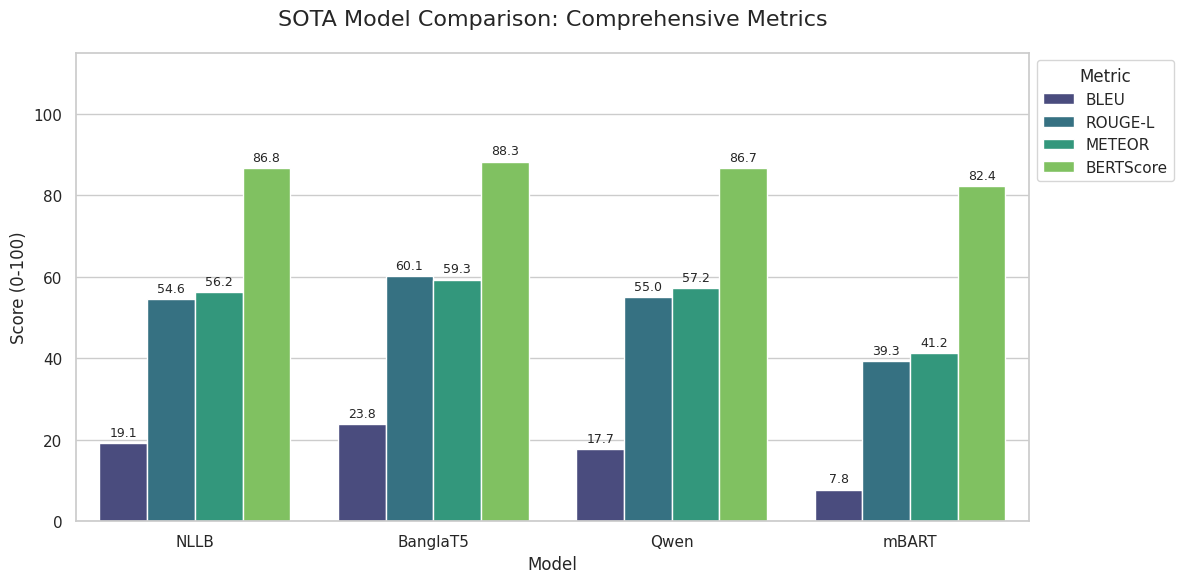

In [10]:
import pandas as pd
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch

# SETUP & LOAD RESOURCES
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('punkt_tab')

# Load all 4 metrics
print("Loading metrics...")
sacrebleu = evaluate.load("sacrebleu")
bertscore = evaluate.load("bertscore")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# CALCULATE METRICS
final_scores = []

# Define models to test
models = ['NLLB', 'BanglaT5', 'Qwen', 'mBART']
models = [m for m in models if m in results_df.columns]

# Prepare references
refs_bleu = [[str(r)] for r in results_df['Reference'].tolist()]

refs_flat = [str(r) for r in results_df['Reference'].tolist()]

print(f"{'Model':<10} | {'BLEU':<6} | {'ROUGE':<6} | {'METEOR':<6} | {'BERT':<6}")
print("-" * 55)

for m in models:
    preds = [str(p) for p in results_df[m].tolist()]

    # BLEU (Precision)
    bleu = sacrebleu.compute(predictions=preds, references=refs_bleu)['score']

    # BERTScore (Semantic Meaning)
    bert = bertscore.compute(
        predictions=preds,
        references=refs_flat,
        lang='en',
        model_type='distilbert-base-uncased'
    )
    bert_f1 = sum(bert['f1']) / len(bert['f1']) * 100

    # ROUGE-L (Recall / Structure)
    rouge_res = rouge.compute(predictions=preds, references=refs_flat)
    rouge_l = rouge_res['rougeL'] * 100

    # METEOR (Synonyms)
    meteor_res = meteor.compute(predictions=preds, references=refs_flat)
    met_score = meteor_res['meteor'] * 100

    # Store results
    final_scores.append({
        'Model': m,
        'BLEU': bleu,
        'ROUGE-L': rouge_l,
        'METEOR': met_score,
        'BERTScore': bert_f1
    })

    print(f"{m:<10} | {bleu:.1f}   | {rouge_l:.1f}   | {met_score:.1f}   | {bert_f1:.1f}")

metrics_df = pd.DataFrame(final_scores)


# VISUALIZATION
plot_df = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Set Theme
sns.set_theme(style="whitegrid")
# Increased figure width to accommodate 4 bars per model
plt.figure(figsize=(12, 6))

# Create Grouped Bar Chart
chart = sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric", palette="viridis")

# Add numbers on top of bars
for i in chart.containers:
    chart.bar_label(i, fmt='%.1f', padding=3, fontsize=9)

plt.title("SOTA Model Comparison: Comprehensive Metrics", fontsize=16, pad=20)
plt.ylabel("Score (0-100)", fontsize=12)
plt.ylim(0, 115) # More headroom for labels
plt.legend(title="Metric", loc='upper left', bbox_to_anchor=(1, 1)) # Legend outside to save space
plt.tight_layout()

plt.show()

### Model Performance Matrix (Heatmap)

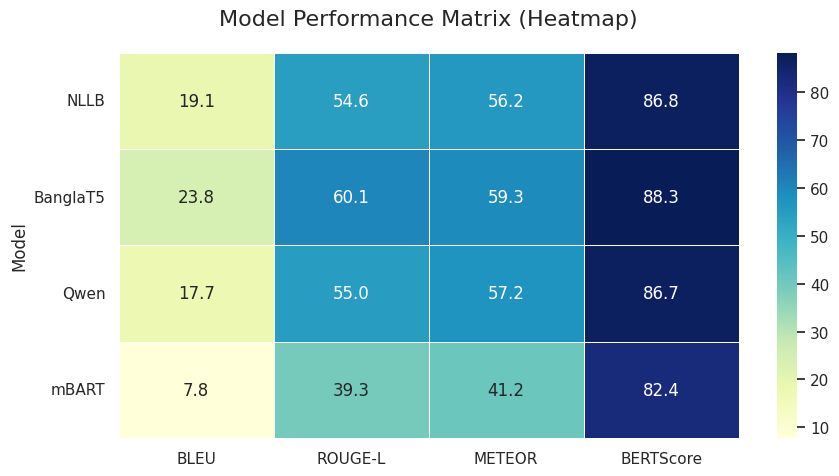

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare Data for Heatmap
heatmap_data = metrics_df.set_index('Model')

# Plot
plt.figure(figsize=(10, 5))
sns.set_theme(style="white")

# Create Heatmap
# annot=True puts the numbers in the boxes
# cmap="YlGnBu" creates a Yellow-Green-Blue color gradient
# fmt=".1f" formats numbers to 1 decimal place
sns.heatmap(data=heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)

plt.title("Model Performance Matrix (Heatmap)", fontsize=16, pad=20)
plt.yticks(rotation=0)
plt.show()

In [12]:
import nbformat
# This cleans the current notebook's metadata
# Note: You'll need to download the file and upload manually to GitHub
def fix_notebook_metadata(input_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)
    if 'widgets' in nb.metadata:
        del nb.metadata['widgets']
    with open(input_file, 'w', encoding='utf-8') as f:
        nbformat.write(nb, f)